**BU PROJEDE NEYİ AMAÇLIYORUZ?**

Bu veri seti, kullanıcıların müzik tercihlerini analiz ederek bir şarkının beğenilip beğenilmeyeceğini tahmin etmeye odaklanıyor.
Bu tahminler, çeşitli müzik özelliklerine dayanarak yapılır.

1.   Danceability: Dans edilebilirlik
2.   Energy: Enerji
3.   Key: Müzikal anahtar (nota)
4.   Loudness: Gürültü seviyesi (desibel)
5.   Mode: Müzikal mod (majör/minör)
6.   Speechiness: Konuşma oranı
7.   Acousticness: Akustik oranı
8.   Instrumentalness: Enstrümantal oran
9.   Liveness: Canlılık oranı
10.  Valence: Neşe oranı (pozitiflik)
11.  Tempo: Tempo (bpm - dakika başına vuruş)
12.  Duration_ms: Süre (milisaniye cinsinden)
13.  Time_signature: Ölçü (müzikal ölçü)
14.  Liked: Beğenildi mi (1: Evet, 0: Hayır)

**Problem**, bu özelliklere göre bir şarkının beğenilip beğenilmediğini (liked sütunu: 1 veya 0) tahmin etmek. Modelleri eğittikten sonra, yeni şarkılar için müzik platformlarında öneri sistemleri geliştirebilir ya da müzik prodüktörlerine şarkıların popüler olma potansiyelini değerlendirmelerinde yardımcı olabiliriz.

**Özellik seçimi**

**Korelasyon Analizi**: Hedef değişkenle en yüksek korelasyona sahip olan özellikleri seçer.
**Random Forest ile Önem Sıralaması**: Rastgele orman modeliyle öznitelik önemini belirler.
**RFE (Recursive Feature Elimination):** Lojistik regresyon ile en iyi özellikleri seçmek için eleme yapar.

**Modellerin Rolü**

Lojistik Regresyon, KNN ve Karar Ağaçları: Bu modeller, verilen müzik özelliklerine dayanarak şarkının beğenilip beğenilmeyeceğini sınıflandırır.

**Çıktılar**

Modellerin performansını karşılaştırarak hangi modelin en doğru tahmini yaptığını bulabiliriz.

Her bir modelin doğruluk, hassasiyet, duyarlılık gibi metrikleriyle performansını değerlendirebiliriz.

*Yani, projenin sonunda elimizde hangi modelin daha iyi performans gösterdiğini belirleyen bir sınıflandırma analizi olacak.*


In [ ]:
import pandas as pd

# Veriyi yükleme
data_path = '/content/data.csv'
data = pd.read_csv(data_path)

# İlk birkaç satırı göster
print(data.head())


   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.803  0.6240    7    -6.764     0       0.0477         0.451   
1         0.762  0.7030   10    -7.951     0       0.3060         0.206   
2         0.261  0.0149    1   -27.528     1       0.0419         0.992   
3         0.722  0.7360    3    -6.994     0       0.0585         0.431   
4         0.787  0.5720    1    -7.516     1       0.2220         0.145   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.000734    0.1000   0.6280   95.968       304524               4   
1          0.000000    0.0912   0.5190  151.329       247178               4   
2          0.897000    0.1020   0.0382   75.296       286987               4   
3          0.000001    0.1230   0.5820   89.860       208920               4   
4          0.000000    0.0753   0.6470  155.117       179413               4   

   liked  
0      0  
1      1  
2      0  
3      1  
4      1  


In [ ]:
# Veri tiplerini kontrol et
print(data.dtypes)

# Kategorik değişkenlerin sayısallaştırılması
# Örneğin, 'liked' dışındaki diğer kategorik sütunlar varsa:
categorical_columns = data.select_dtypes(include=['object']).columns

# Get dummies ile sayısallaştırma işlemi
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Sayısallaştırılmış veri setinin ilk birkaç satırını göster
print(data.head())


danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
liked                 int64
dtype: object
   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.803  0.6240    7    -6.764     0       0.0477         0.451   
1         0.762  0.7030   10    -7.951     0       0.3060         0.206   
2         0.261  0.0149    1   -27.528     1       0.0419         0.992   
3         0.722  0.7360    3    -6.994     0       0.0585         0.431   
4         0.787  0.5720    1    -7.516     1       0.2220         0.145   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  \
0          0.000734    0.1000   0.6280   95.968       304524   

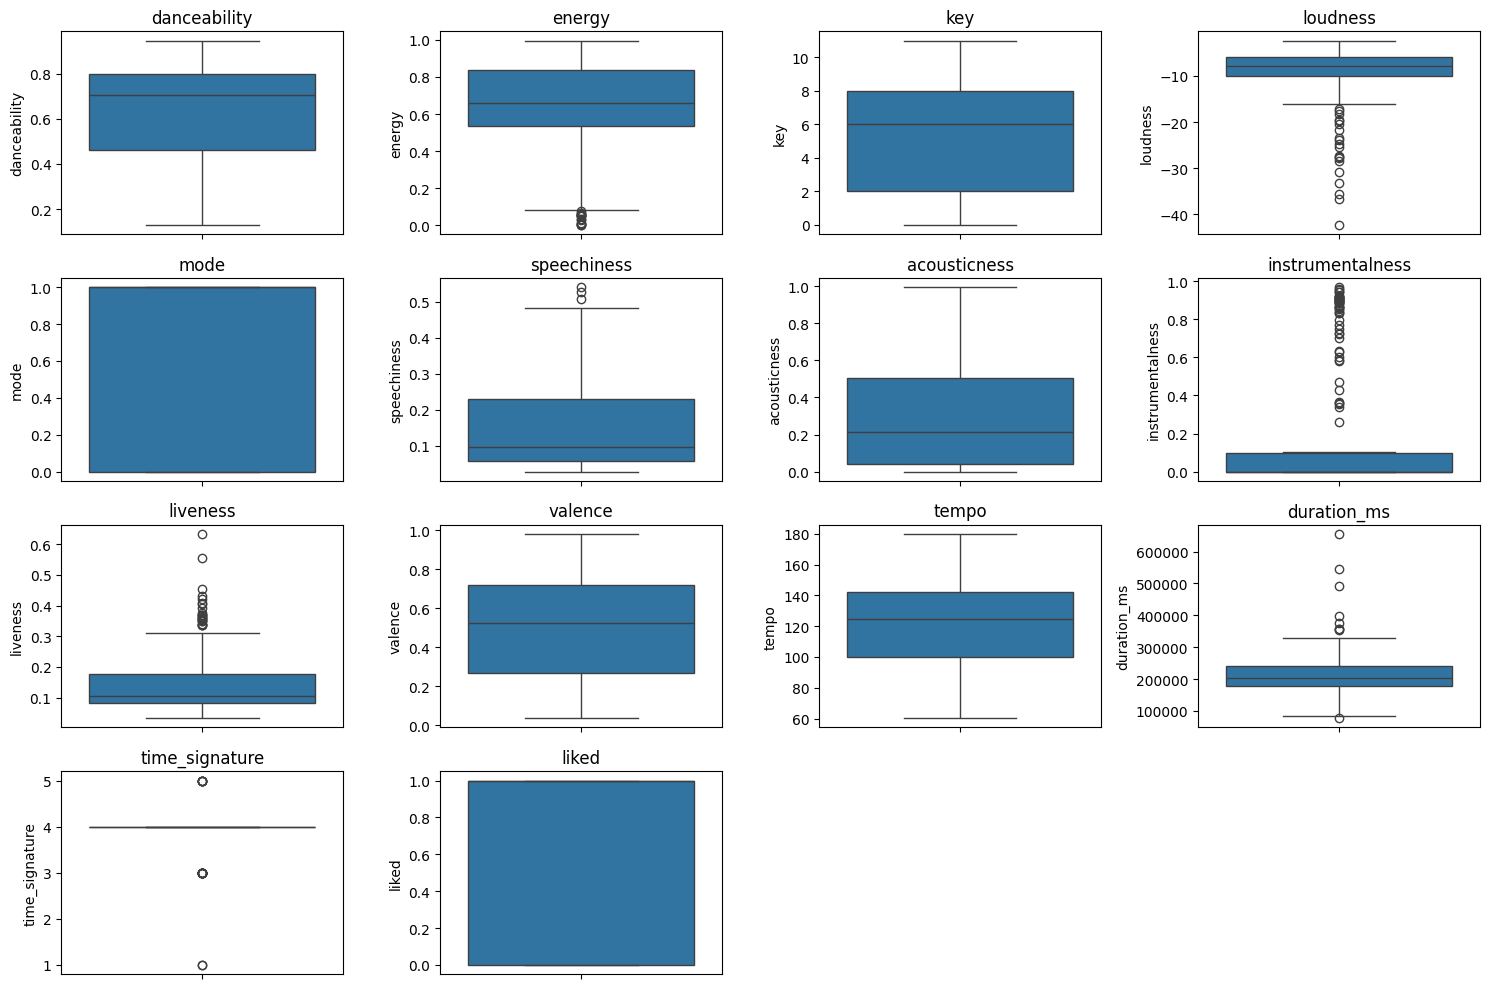

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sayısal sütunları tanımla
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Her bir sütun için box plot çiz
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data[col])
    plt.title(col)

plt.tight_layout()
plt.show()


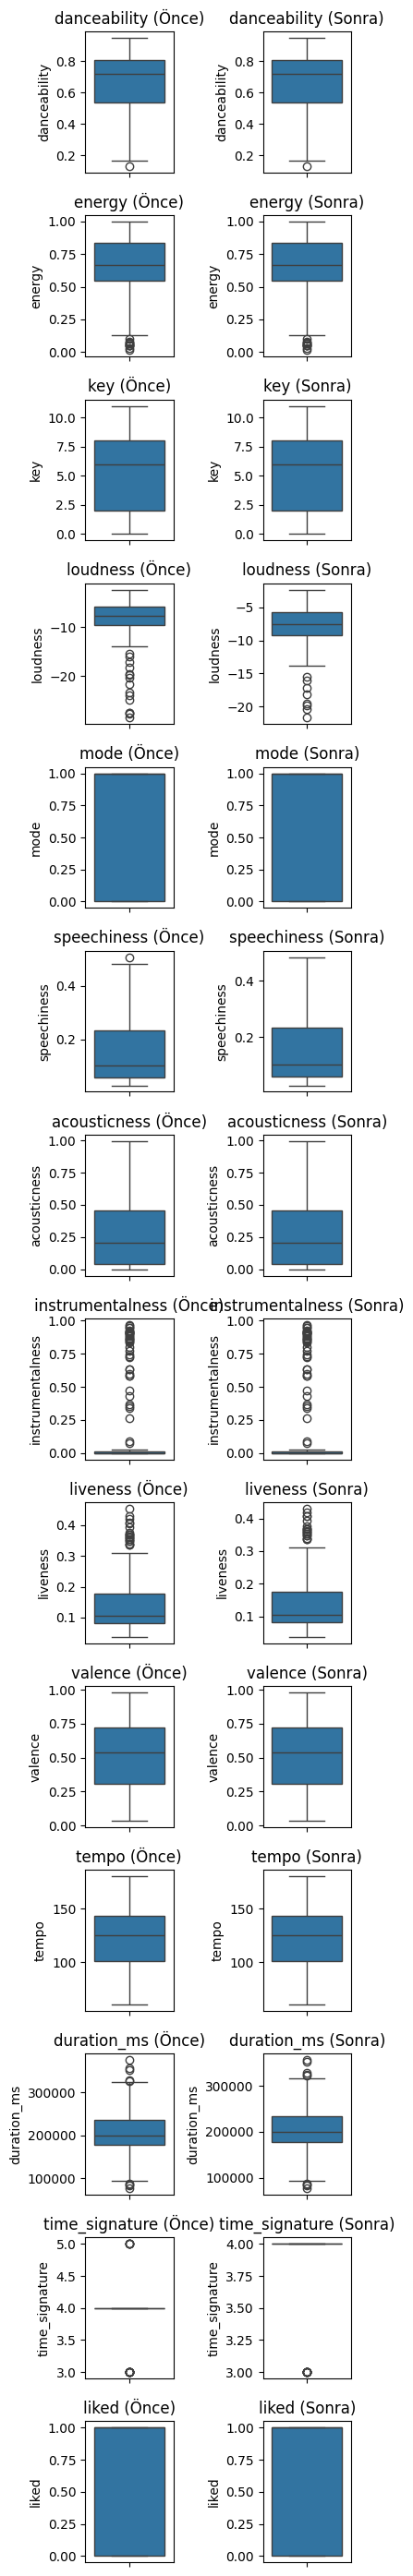

In [ ]:
# Tüm sayısal sütunlar için Z-skoru yöntemiyle aykırı değer temizleme öncesi ve sonrası kutu grafiği
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Z-skoru yöntemiyle aykırı değerleri tespit ve temizleme fonksiyonu
def remove_outliers_zscore(df, col, threshold=3):
    """
    Z-skoru ile aykırı değerleri tespit ve temizleme fonksiyonu.
    - df: Veri çerçevesi (pandas DataFrame)
    - col: Aykırı değerlerin kontrol edileceği sütun ismi (string)
    - threshold: Z-skoru eşiği (genellikle 3 veya 4 kullanılır)
    """
    mean = df[col].mean()
    std = df[col].std()
    z_score = (df[col] - mean) / std

    return df[np.abs(z_score) < threshold]

# Tüm sayısal sütunlar için Z-skoru öncesi ve sonrası kutu grafiği
def plot_before_after_zscore(df, numeric_columns, threshold=3):
    """
    Her sayısal sütun için Z-skoru yöntemiyle aykırı değer temizleme öncesi ve sonrası grafikleri çiz.
    - df: Veri çerçevesi (pandas DataFrame)
    - numeric_columns: Sayısal sütunların isimlerini içeren liste (List of strings)
    - threshold: Z-skoru eşiği (genellikle 3 veya 4 kullanılır)
    """
    num_cols = len(numeric_columns)
    fig, axes = plt.subplots(num_cols, 2, figsize=(4, 2 * num_cols))

    for i, col in enumerate(numeric_columns):
        # Temizleme öncesi grafiği
        sns.boxplot(df[col], ax=axes[i, 0])
        axes[i, 0].set_title(f'{col} (Önce)')

        # Z-skoru yöntemiyle temizle ve sonrası grafiği
        clean_df = remove_outliers_zscore(df, col, threshold)
        sns.boxplot(clean_df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'{col} (Sonra)')

    fig.tight_layout()
    plt.show()

# Tüm sayısal sütunlar için grafikleri göster
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
plot_before_after_zscore(data, numeric_columns)


**Normalizasyon ve test eğitim setlerini ayırma aşaması**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Aykırı değerler temizlenmiş veri seti ve hedef değişkeni
X = data.drop(columns='liked')
y = data['liked']

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Min-Max Normalizasyon işlemi
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalleştirilmiş eğitim ve test setlerinin ilk birkaç satırını göster
train_df = pd.DataFrame(X_train_scaled, columns=X.columns).head()
test_df = pd.DataFrame(X_test_scaled, columns=X.columns).head()

print("Eğitim Seti (Normalleştirilmiş):")
print(train_df)

print("\nTest Seti (Normalleştirilmiş):")
print(test_df)


Eğitim Seti (Normalleştirilmiş):
   danceability    energy       key  loudness  mode  speechiness  \
0      0.817402  0.651412  0.727273  0.807432   1.0     0.453255   
1      0.883578  0.684028  1.000000  0.777994   1.0     0.405259   
2      0.197304  0.983692  0.090909  0.892878   1.0     0.261269   
3      0.204657  0.976557  0.090909  0.917078   1.0     0.257095   
4      0.579657  0.887881  0.454545  0.944910   0.0     0.116653   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      0.636180          0.000000  0.164459  0.640097  0.707592     0.341462   
1      0.599999          0.000001  0.176499  0.758654  0.790210     0.423226   
2      0.001273          0.094693  0.154828  0.234678  0.160471     0.693968   
3      0.001464          0.955255  0.243920  0.210331  0.352799     0.334297   
4      0.000449          0.000000  0.535276  0.380756  0.547666     0.547137   

   time_signature  
0             0.5  
1             0.5  
2             0.5

***Korelasyon Analizi***

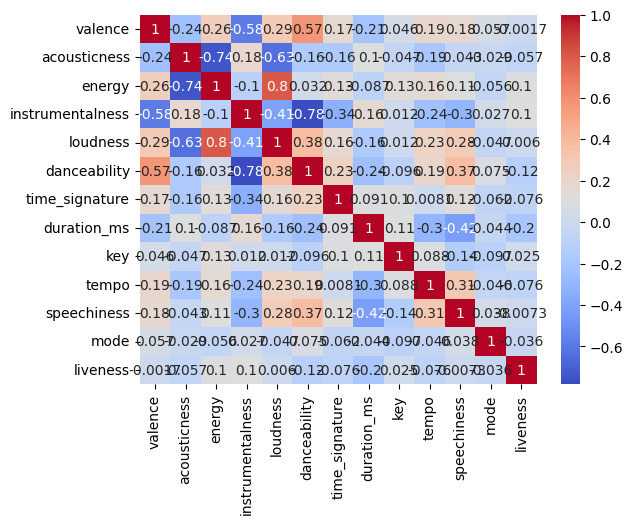

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Korelasyon matrisini oluştur
corr_matrix = pd.DataFrame(X_train_scaled, columns=X.columns).corrwith(pd.Series(y_train))

# Hedef değişkenle en yüksek korelasyona sahip özellikleri göster
top_corr_features = corr_matrix.abs().sort_values(ascending=False).index
sns.heatmap(pd.DataFrame(X_train_scaled, columns=X.columns)[top_corr_features].corr(), annot=True, cmap='coolwarm')
plt.show()

***Random Forest***

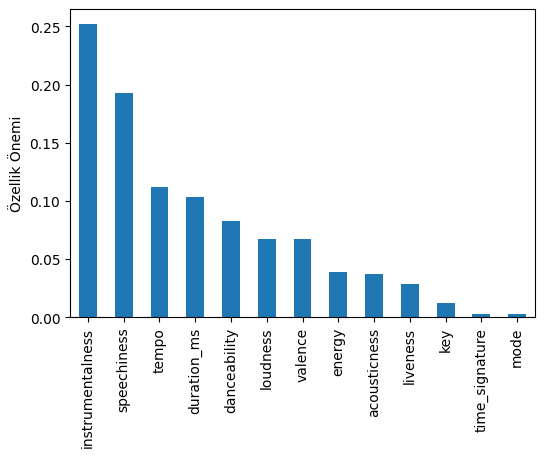

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Rastgele Orman modeliyle en önemli özellikleri bul
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_scaled, y_train)

# Özellik önemlerini göster
feature_importances_rf = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances_rf.plot(kind='bar', figsize=(6, 4))
plt.ylabel('Özellik Önemi')
plt.show()

***Recursive Feature Elimination***

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Lojistik Regresyon modeli ile RFE uygulayın
model_lr = LogisticRegression(max_iter=1000, random_state=42)
rfe = RFE(model_lr, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train)

# Seçilen özellikleri göster
selected_features_rfe = X.columns[rfe.support_]
print("RFE ile Seçilen Özellikler:", selected_features_rfe)

RFE ile Seçilen Özellikler: Index(['danceability', 'loudness', 'speechiness', 'instrumentalness',
       'duration_ms'],
      dtype='object')


<Figure size 640x480 with 0 Axes>

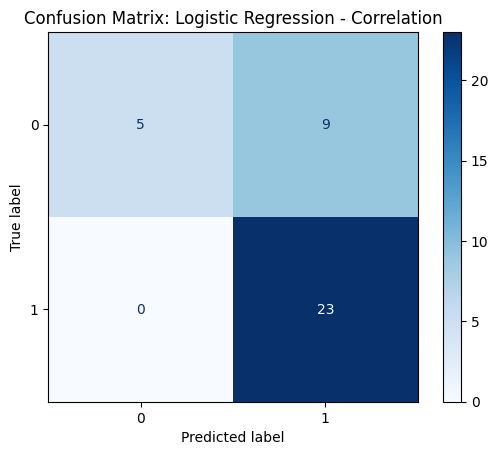

Model: Logistic Regression, Feature Set: Correlation, Accuracy: 0.7567567567567568


<Figure size 640x480 with 0 Axes>

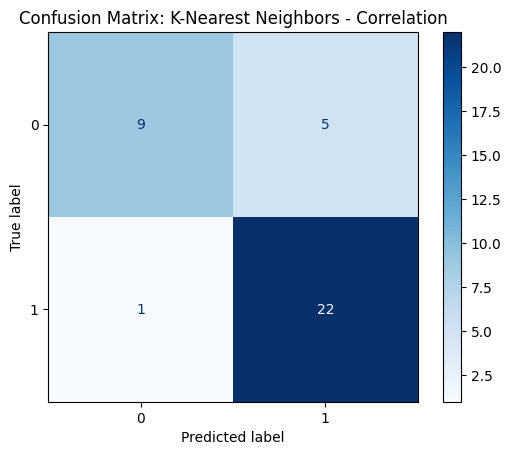

Model: K-Nearest Neighbors, Feature Set: Correlation, Accuracy: 0.8378378378378378


<Figure size 640x480 with 0 Axes>

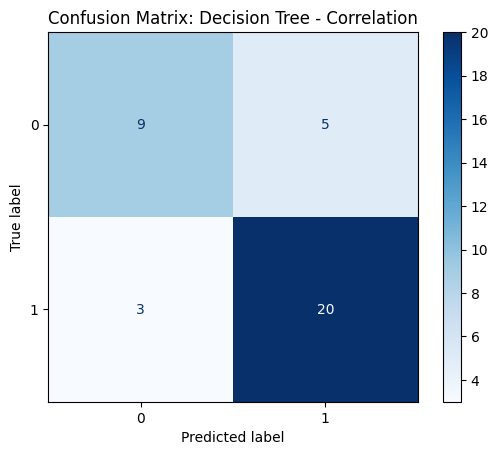

Model: Decision Tree, Feature Set: Correlation, Accuracy: 0.7837837837837838


<Figure size 640x480 with 0 Axes>

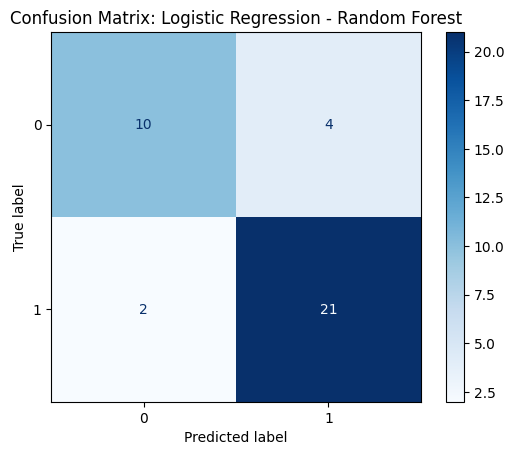

Model: Logistic Regression, Feature Set: Random Forest, Accuracy: 0.8378378378378378


<Figure size 640x480 with 0 Axes>

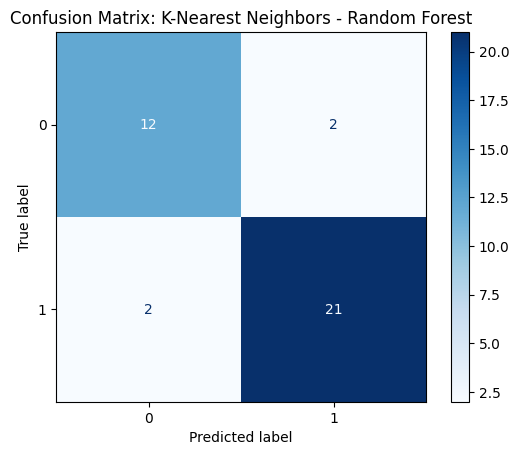

Model: K-Nearest Neighbors, Feature Set: Random Forest, Accuracy: 0.8918918918918919


<Figure size 640x480 with 0 Axes>

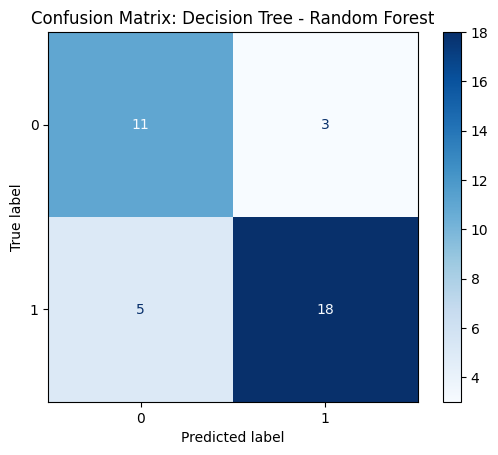

Model: Decision Tree, Feature Set: Random Forest, Accuracy: 0.7837837837837838


<Figure size 640x480 with 0 Axes>

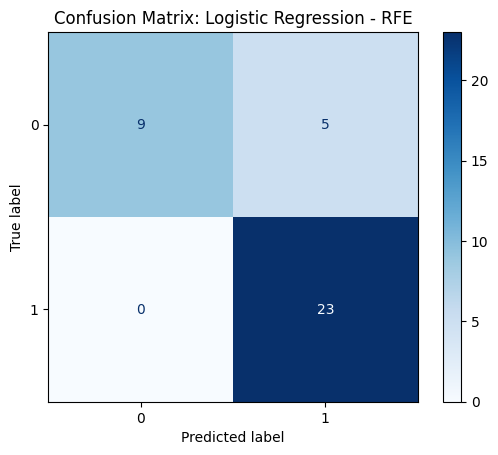

Model: Logistic Regression, Feature Set: RFE, Accuracy: 0.8648648648648649


<Figure size 640x480 with 0 Axes>

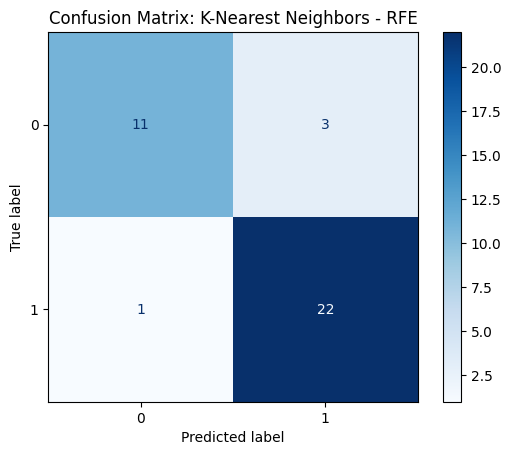

Model: K-Nearest Neighbors, Feature Set: RFE, Accuracy: 0.8918918918918919


<Figure size 640x480 with 0 Axes>

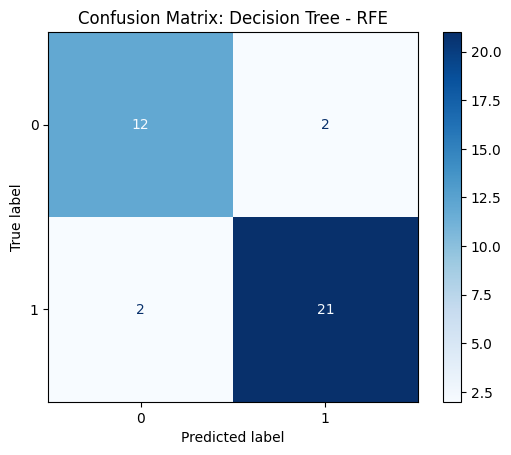

Model: Decision Tree, Feature Set: RFE, Accuracy: 0.8918918918918919


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Model tanımlamaları
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# Özellik setleri
feature_sets = {
    "Correlation": top_corr_features[:5],  # En yüksek korelasyonlu 5 özellik
    "Random Forest": feature_importances_rf.index[:5],  # En önemli 5 özellik
    "RFE": selected_features_rfe  # RFE'den seçilen özellikler
}

# Her özellik seti ve model için sonuçları sakla
results = {}

for feature_set_name, features in feature_sets.items():
    # Eğitim ve test setlerini ilgili özelliklere göre filtrele
    X_train_fs = pd.DataFrame(X_train_scaled, columns=X.columns)[features]
    X_test_fs = pd.DataFrame(X_test_scaled, columns=X.columns)[features]
    results[feature_set_name] = {}

    for model_name, model in models.items():
        # Modeli eğit ve test verisi üzerinde tahmin yap
        model.fit(X_train_fs, y_train)
        y_pred = model.predict(X_test_fs)

        # Doğruluk oranını hesapla
        accuracy = accuracy_score(y_test, y_pred)
        results[feature_set_name][model_name] = accuracy

        # Karışıklık matrisini hesapla
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        # Karışıklık matrisini çiz
        plt.figure()
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix: {model_name} - {feature_set_name}")
        plt.show()

        print(f"Model: {model_name}, Feature Set: {feature_set_name}, Accuracy: {accuracy}")


<Figure size 640x480 with 0 Axes>

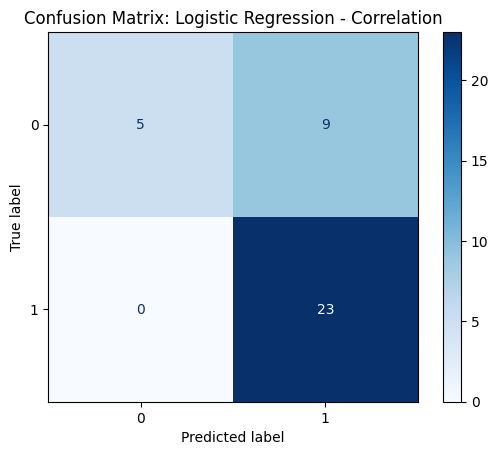

<Figure size 640x480 with 0 Axes>

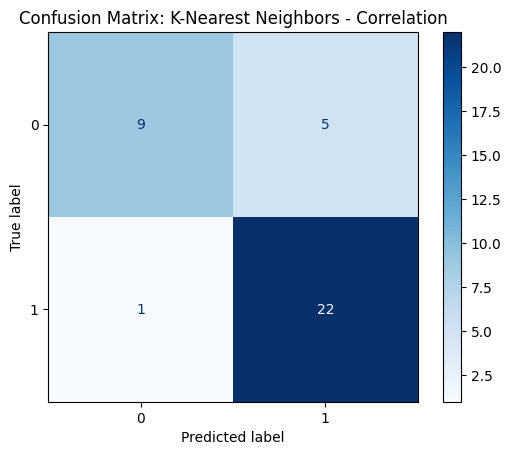

<Figure size 640x480 with 0 Axes>

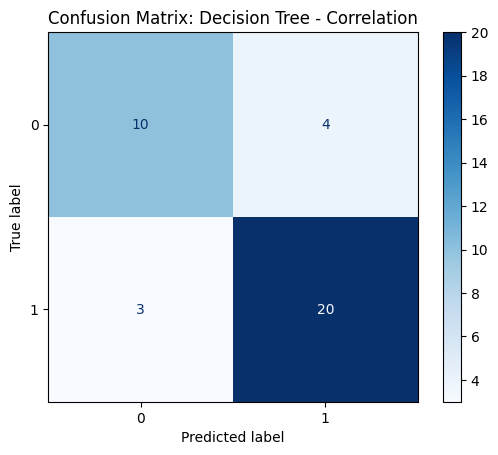

<Figure size 640x480 with 0 Axes>

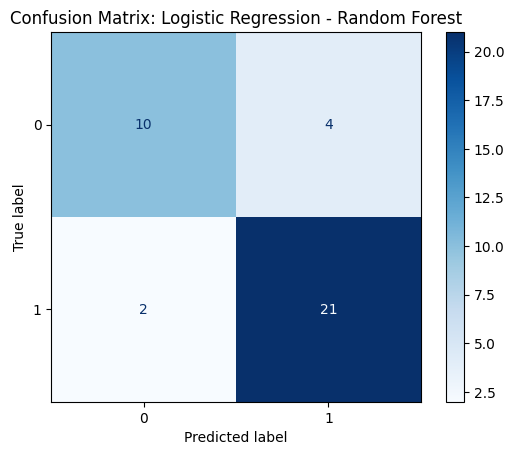

<Figure size 640x480 with 0 Axes>

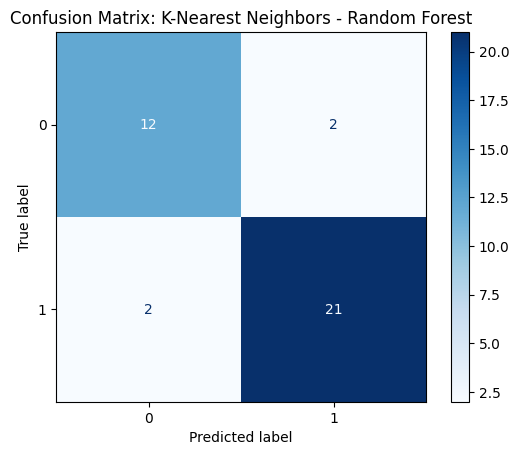

<Figure size 640x480 with 0 Axes>

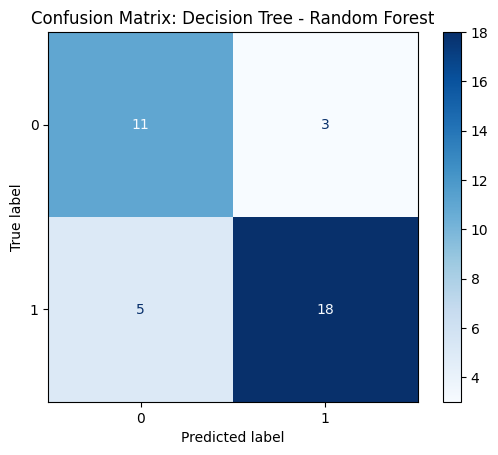

<Figure size 640x480 with 0 Axes>

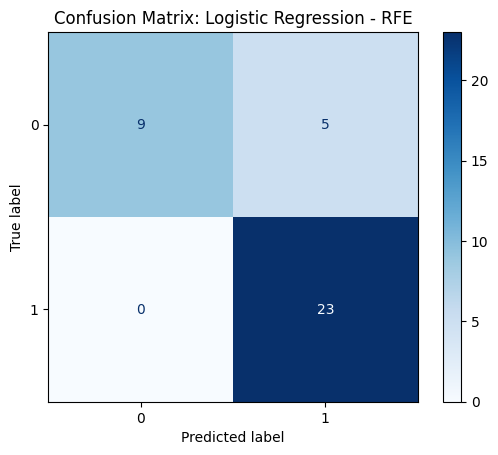

<Figure size 640x480 with 0 Axes>

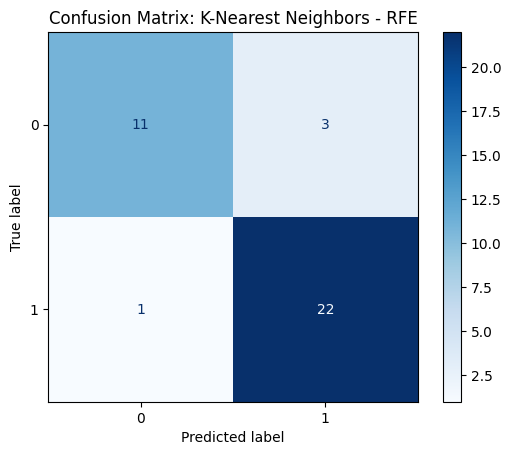

<Figure size 640x480 with 0 Axes>

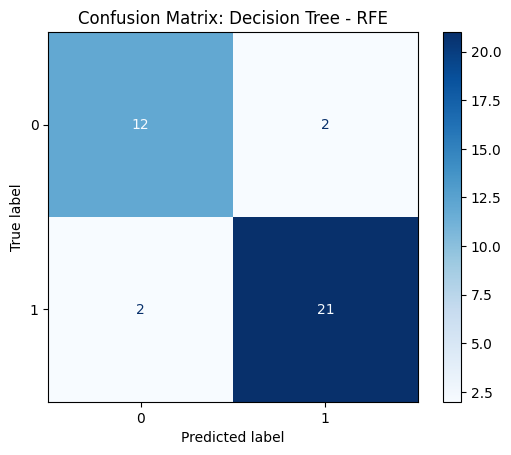

     Feature Set                Model  Accuracy  Precision    Recall
0    Correlation  Logistic Regression  0.756757   0.825169  0.756757
1    Correlation  K-Nearest Neighbors  0.837838   0.847047  0.837838
2    Correlation        Decision Tree  0.810811   0.809078  0.810811
3  Random Forest  Logistic Regression  0.837838   0.837477  0.837838
4  Random Forest  K-Nearest Neighbors  0.891892   0.891892  0.891892
5  Random Forest        Decision Tree  0.783784   0.792954  0.783784
6            RFE  Logistic Regression  0.864865   0.888996  0.864865
7            RFE  K-Nearest Neighbors  0.891892   0.893874  0.891892
8            RFE        Decision Tree  0.891892   0.891892  0.891892


In [ ]:
# Başlangıçta boş bir liste oluştur
results = []

# Her özellik seti ve model için sonuçları topla
for feature_set_name, features in feature_sets.items():
    # Eğitim ve test setlerini ilgili özelliklere göre filtrele
    X_train_fs = pd.DataFrame(X_train_scaled, columns=X.columns)[features]
    X_test_fs = pd.DataFrame(X_test_scaled, columns=X.columns)[features]

    for model_name, model in models.items():
        # Modeli eğit ve test verisi üzerinde tahmin yap
        model.fit(X_train_fs, y_train)
        y_pred = model.predict(X_test_fs)

        # Doğruluk, kararlılık ve hassasiyet metriklerini hesapla
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        # Sonuçları listeye ekle
        results.append({
            "Feature Set": feature_set_name,
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall
        })

        # Karışıklık matrisini hesapla ve görselleştir
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        plt.figure()
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix: {model_name} - {feature_set_name}")
        plt.show()

# Listeyi bir DataFrame'e dönüştür
results_df = pd.DataFrame(results)

# Tüm sonuçları göster
print(results_df)
